# Chargement des données :

Pour le projet **DeepLearning**, On classifie des affiches de films associées aux 9 labels suivants : **crime**, **documentary**, **family**, **history**, **horror**, **romance**, **science-fiction**, **war**, **western**.

Les images sont dans le dossier **bdd** répartit en 3 dossiers: *train*, *validation* et *test*. Chacun de ces dossiers comporte un sous-dossier par classe, qui contient les images correspondantes. L'arborescence est disponible sur le [github du projet](https://github.com/GeogeoB/DeepLearning).

Nous pouvons donc faire **git clone** pour récupérer le projet et la base de données.

In [22]:
!git clone https://github.com/GeogeoB/DeepLearning
path = "./DeepLearning/bdd/"

!pip install -q -U albumentations


fatal: destination path 'DeepLearning' already exists and is not an empty directory.


Fonction pour charger les images dans une matrice X et les classes associées dans une matrice y.

In [23]:

import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset='train', image_size=(64,64), max_par_categorie=200):
    image_sizeY = image_size[0]
    image_sizeX = image_size[1]
  
    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        #num_images += len(dirs)
        num_images += min(max_par_categorie,len(dirs))
                                
    x = np.zeros((num_images, image_sizeY, image_sizeX, 3))
    y = np.zeros((num_images, ), dtype=np.uint8)
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        #num_images += len(dirs)
        num_images += max_par_categorie
    
        # Chargement des images,
        #for idx_img in range(len(dirs)):
        for idx_img in range(min(max_par_categorie,len(dirs))):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_sizeX,image_sizeY))
                x[current_index] = np.asarray(img)/255.0
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

Création des 3 matrices (X,y) associées aux 3 groupes *train*, *eval* et *test*.

In [24]:
LABELS = ['crime', 'documentary', 'family', 'history', 'horror', 'romance', 'science-fiction', 'war', "western"]
NCLASS = len(LABELS)
IMAGE_SIZE = (345,230) # 345 pixel de haut, 230 de large
IMAGE_SIZE = (172,115)

x_train, y_train = load_data(path, LABELS, dataset='Apprentissage', image_size=IMAGE_SIZE)
print("Taille X_train:", x_train.shape, "Taille y_train:", y_train.shape)

x_val, y_val = load_data(path, LABELS, dataset='Evaluation', image_size=IMAGE_SIZE)
print("Taille X_val:  ", x_val.shape, " Taille y_val:  ", y_val.shape)

x_test, y_test = load_data(path, LABELS, dataset='Test', image_size=IMAGE_SIZE)
print("Taille X_test: ", x_test.shape, " Taille y_test: ", y_test.shape)

Taille X_train: (1384, 172, 115, 3) Taille y_train: (1384,)
Taille X_val:   (264, 172, 115, 3)  Taille y_val:   (264,)
Taille X_test:  (264, 172, 115, 3)  Taille y_test:  (264,)


Mélanger les x et y pour éviter des problemes d'apprentissage

In [25]:
ordre = list(range(x_train.shape[0]))
x_train = np.array([x_train[i,:,:,:] for i in ordre])
y_train = np.array([y_train[i] for i in ordre])

Afficher une image pour chacun des genres:

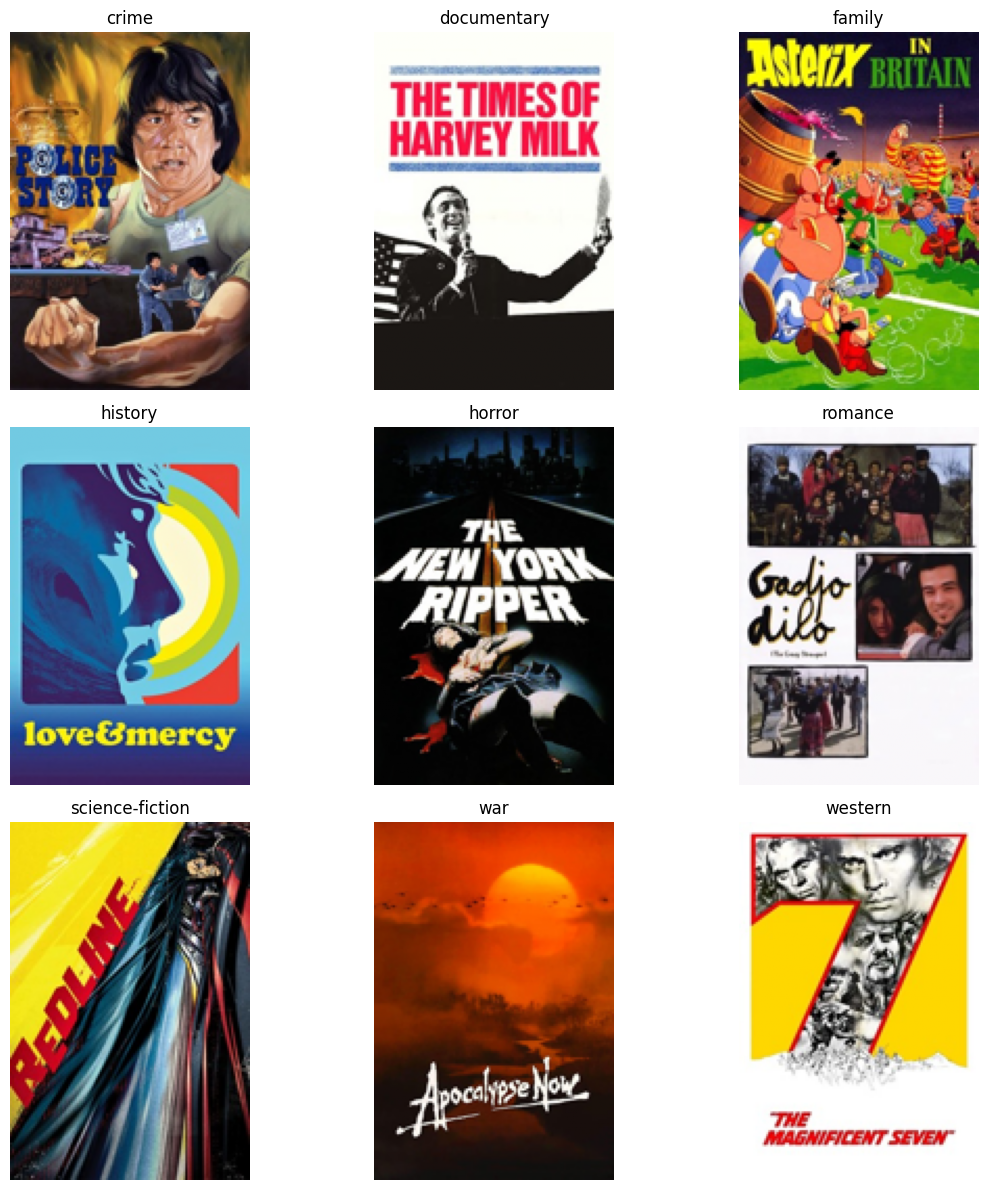

In [26]:
import matplotlib.pyplot as plt
import random

# Dictionnaire pour associer chaque genre les indices dans x_train et y_train
genresIndices = {i: [] for i in range(NCLASS)}
for i, val in enumerate(y_train):
    genresIndices[val].append(i)

plt.figure(figsize=(12, 12))
random_indices = [random.choice(genresIndices[val]) for val in range(NCLASS)]
for i in range(0, NCLASS):
    plt.subplot(3, 3, i+1)
    # Enlever les axes
    plt.axis("off")
    image = x_train[random_indices[i]]
    plt.title(LABELS[y_train[random_indices[i]]])
    plt.imshow(image)

plt.tight_layout()
plt.show()

In [27]:
def plot_training_analysis():
  acc = history.history['sparse_categorical_accuracy']
  val_acc = history.history['val_sparse_categorical_accuracy']
  acc_top = history.history['top_k_categorical_accuracy']
  val_acc_top = history.history['val_top_k_categorical_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'b', linestyle="--",label='Training acc')
  plt.plot(epochs, val_acc, 'g', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, acc_top, 'b', linestyle="--",label='Training acc top 3')
  plt.plot(epochs, val_acc_top, 'g', label='Validation acc top 3')
  plt.title('Training and validation accuracy top 3')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'b', linestyle="--",label='Training loss')
  plt.plot(epochs, val_loss,'g', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

In [28]:
from tensorflow.keras.utils import Sequence

class FILMSequence(Sequence):
    # Initialisation de la séquence avec différents paramètres
    def __init__(self, x_set, y_set, batch_size,augmentations):
        self.x, self.y = x_set, y_set
        self.classes = LABELS
        self.batch_size = batch_size
        self.augment = augmentations
        self.indices1 = np.arange(x_set.shape[0]) 
        np.random.shuffle(self.indices1) # Les indices permettent d'accéder
        # aux données et sont randomisés à chaque epoch pour varier la composition
        # des batches au cours de l'entraînement

    # Fonction calculant le nombre de pas de descente du gradient par epoch
    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))
    
    # Application de l'augmentation de données à chaque image du batch et aux
    # boîtes englobantes associées
    def apply_augmentation(self, bx, by):

        batch_x = np.zeros((bx.shape[0], IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
        batch_y = by
        
        # Pour chaque image du batch
        for i in range(len(bx)):
            img = bx[i].astype('float32')

            # Application de l'augmentation à l'image et aux masques
            transformed = self.augment(image=img.astype('float32'))
            batch_x[i] = transformed['image']
        return batch_x, batch_y

    # Fonction appelée à chaque nouveau batch : sélection et augmentation des données
    def __getitem__(self, idx):
        batch_x = self.x[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_y = self.y[self.indices1[idx * self.batch_size:(idx + 1) * self.batch_size]]
        batch_x, batch_y = self.apply_augmentation(batch_x, batch_y)
        
        batch_y = np.array(batch_y)
        return np.array(batch_x), batch_y

    # Fonction appelée à la fin d'un epoch ; on randomise les indices d'accès aux données
    def on_epoch_end(self):
        np.random.shuffle(self.indices1)
        


In [29]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from albumentations import (Compose, RandomBrightnessContrast, HorizontalFlip, GaussNoise, Sharpen)
import albumentations as A


transforms = Compose([
    HorizontalFlip(),
    RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    Sharpen(),
    GaussNoise(var_limit=(0.0, 0.01))
    ],)

# create dataset
train_gen = FILMSequence(x_train, y_train, 64, augmentations=transforms)


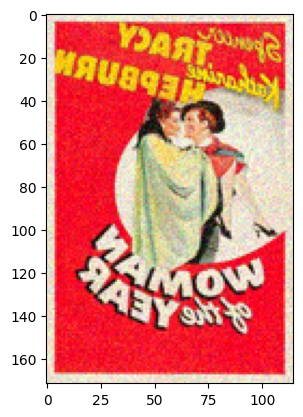

In [30]:
plt.imshow(train_gen[0][0][13])

In [31]:
from keras.api._v2.keras import regularizers
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras import optimizers

loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=None,
    name='crossentropy'
)
#train_generator = batch_generator(x_train, y_train, batch_size = 64)


from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
conv_base.trainable = False
print(conv_base.summary())


model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.L2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.L2(0.05)))
model.add(Dropout(0.5))
model.add(Dense(NCLASS, 'softmax'))   # Couche de sortie


print(model.summary())

model.compile(loss=loss,
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=3)])


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 172, 115, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 172, 115, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 172, 115, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 86, 57, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 86, 57, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 86, 57, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 43, 28, 128)       0     

In [32]:
history = model.fit(train_gen, 
                    validation_data=(x_val, y_val),
                    epochs=40,
                    )
''' history = model.fit(x_train, y_train, batch_size=64, 
                    validation_data=(x_val, y_val),
                    epochs=20,
                    ) '''

Epoch 1/40
22/22 [==============================] - 6s 212ms/step - loss: 75.0927 - sparse_categorical_accuracy: 0.1199 - top_k_categorical_accuracy: 0.4660 - val_loss: 52.2922 - val_sparse_categorical_accuracy: 0.0720 - val_top_k_categorical_accuracy: 0.9697
Epoch 2/40
22/22 [==============================] - 4s 192ms/step - loss: 38.4630 - sparse_categorical_accuracy: 0.1329 - top_k_categorical_accuracy: 0.2449 - val_loss: 26.1468 - val_sparse_categorical_accuracy: 0.0758 - val_top_k_categorical_accuracy: 0.1553
Epoch 3/40
22/22 [==============================] - 4s 190ms/step - loss: 19.4627 - sparse_categorical_accuracy: 0.1185 - top_k_categorical_accuracy: 0.5152 - val_loss: 13.6737 - val_sparse_categorical_accuracy: 0.0606 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/40
22/22 [==============================] - 4s 197ms/step - loss: 10.6770 - sparse_categorical_accuracy: 0.1431 - top_k_categorical_accuracy: 0.7666 - val_loss: 8.2182 - val_sparse_categorical_accuracy: 0.2538 - 

' history = model.fit(x_train, y_train, batch_size=64, \n                    validation_data=(x_val, y_val),\n                    epochs=20,\n                    ) '

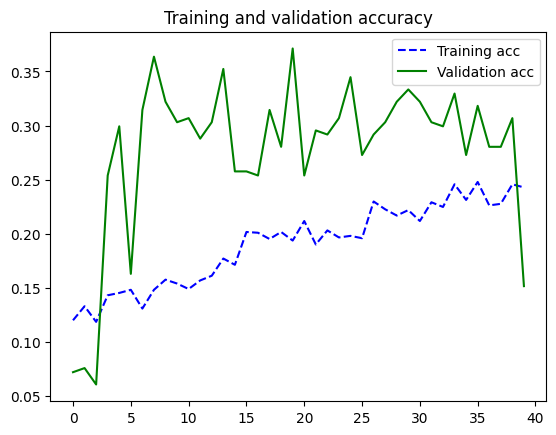

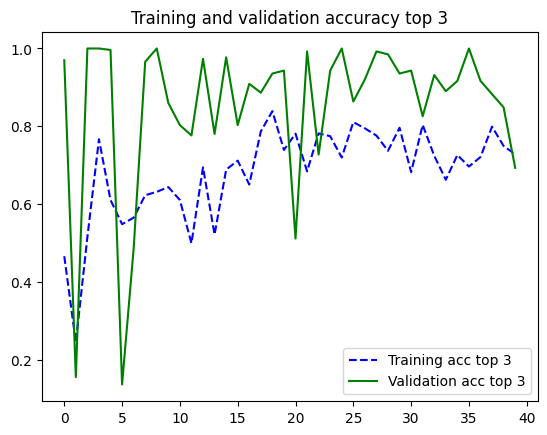

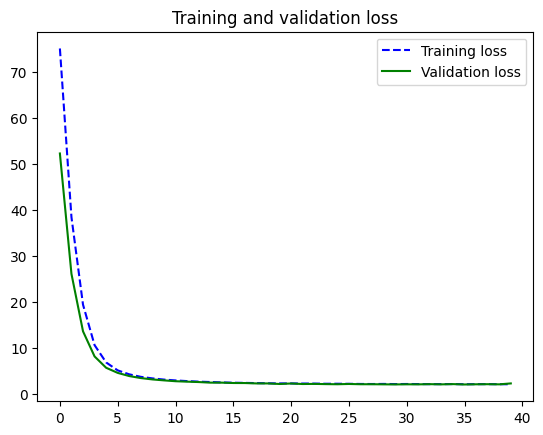

In [33]:
plot_training_analysis()

9/9 [==============================] - 1s 53ms/step


<Axes: >

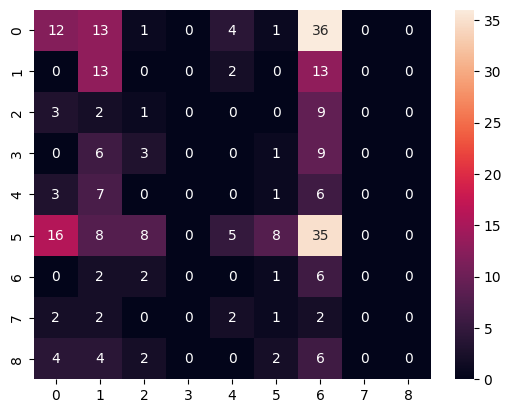

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_prediction = model.predict(x_val)
y_prediction = np.argmax (y_prediction, axis = 1)
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(y_val, y_prediction).round(2)
sns.heatmap(result, annot=True)